# Running Classifiers 
**V.0.1 - Alpha testing, [contributions](#contributions)**

For this script we will use a localizer dataset from [Kim et al. (2017)](https://doi.org/10.1523/JNEUROSCI.3272-16.2017) again. Just to recap: The localizer consisted of 3 runs with 5 blocks of each category (faces, scenes and objects) per run. Within a block, a stimulus was presented every 1.5s (1 TR). Between blocks, there was 15s (10 TRs) of fixation. Each run was 310 TRs. In the matlab stimulus file, the first row codes for the stimulus category for each trial (1 = Faces, 2 = Scenes, 3 = Objects). The 3rd row contains the time (in seconds, relative to the start of the run) when the stimulus was presented for each trial.

By this stage of analysis, you should have completed motion correction and any other required pre-processing on the fMRI data. In this example, all the data have been pre-processed for you.


## Goal of this script
Using this script you will be able to use a classifier on your dataset. Additionally, you will be familiarized with the use of functions in your code. Specifically, we will accomplish the following:  
>1. Assign labels to every time-point (TR) in the dataset
>2. Time-shift the signal to be classified, taking into consideration the delayed hemodynamic response
>3. Collect BOLD data for all runs into one array
>4. Test out the following classifiers on a group of subjects with a fixed set of parameters:    
>    - Gaussian Naive Bayes  
>    - Support Vector Machine
>5. Compute basic statistics to estimate means and confidence intervals         

## Table of Contents
[1. Preprocess the data](#preprocess_data)  
>[1.1 Label fMRI data](#label_data)  
>[1.2 Plot the different conditions](#plot_boxcar)  
>[1.3 Hemodynamic Lag: Time shift the labels](#label_shift)  
>[1.4 Load the fMRI data](#load_fmri)  

[2. Classification](#classification)  
>[2.1 Reshape data](#reshape)  
>[2.2 Model training](#model_training)  
>[2.3 Model testing](#model_testing)  
>[2.4 Test across participants](#across_ppts)  

Exercises
>[Exercise 1](#ex1)  
>[Exercise 2](#ex2)  
>[Exercise 3](#ex3)  
>[Exercise 4](#ex4)  
>[Exercise 5](#ex5)  
>[Exercise 6](#ex6)  
>[Exercise 7](#ex7)  
>[Exercise 8](#ex8)  

[Novel contribution](#novel)



In [1]:
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import nibabel as nib
import numpy as np
from nilearn.input_data import NiftiMasker
import scipy.io
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns 

from brainiak.utils.fmrisim import _double_gamma_hrf as hrf_func

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import PredefinedSplit
from sklearn.preprocessing import StandardScaler

# load some helper functions
from qutils import load_vdc_stim_labels, load_vdc_mask, load_vdc_epi_data, load_vdc_masked_data
# load some constants
from qutils import vdc_data_dir, vdc_all_ROIs, vdc_label_dict, vdc_n_runs

%matplotlib inline 
%autosave 5
sns.set(style = 'white', context='poster', rc={"lines.linewidth": 2.5})

print('data dir = %s' % (vdc_data_dir))
print('ROIs = %s' % (vdc_all_ROIs))
print('Labels = %s' % (vdc_label_dict))
print('number of runs = %d' % (vdc_n_runs))

Autosaving every 5 seconds
data dir = /home/pytorch51/public_FMRI/vdc/
ROIs = ['FFA', 'PPA']
Labels = {1: 'Faces', 2: 'Scenes', 3: 'Objects'}
number of runs = 3


## 1. Preprocess the data <a id="preprocess_data"></a>

As per the procedure used for the exercise in week 2, load in the vdc dataset. To load in the data we are going to first run a series of commands that set the variable name and then store the data. The timing data are stored as a matrix by concatenating all runs.

Last time, you used a function called `load_vdc_stim_labels(subject_name)`, which import the labels for the fMRI data. The cell belows shows source code for that function: 

In [2]:
# Set the variables
sub = 'sub-01';

# Preset the variable size
stim_label = [];
stim_label_allruns = [];
for run in range(1, vdc_n_runs+1):
    
    # Specify the input variables
    in_file= (vdc_data_dir + sub + '/ses-day2/design_matrix/' + '%s_localizer_0%d.mat' % (sub, run))

    # Load in data from matlab
    stim_label = scipy.io.loadmat(in_file);
    stim_label = np.array(stim_label['data']);

    # Store the data
    if run == 1:
        stim_label_allruns = stim_label;
    else:       
        stim_label_allruns = np.hstack((stim_label_allruns, stim_label))

print("Loaded labels for", sub)

Loaded labels for sub-01


Although we can load the data with the set of commands above, this isn't an efficient way to code if we want to re-user these code. A better way to code is to make a **function** that performs the loading of the data and then can be called with different input variables to load in new data. We do this below.

Functions are extremely useful for many reasons and so should be used everywhere: they allow you to remove redundancy in your code, reduce the likelihood of an error since if you update the function you update all of its uses, and you make your code much more readible.

A useful tutorial on functions is found [here](https://www.datacamp.com/community/tutorials/functions-python-tutorial).

One important thing to be aware of is how variables are shared between your workspace and a function. If you have variables in your workspace (i.e., any variables you have created in the usage of jupyter) then they will usually be accessible/usable in a function, regardless of whether they are used as input parameters. However, any variables you create in a function cannot be used in your workspace if you don't return them as outputs. For this reason it is easier if you keep the names of the variables in your function separate from the names in your workspace. This is turtles all the way down: if you have a function within a function then variables will be shared in the same way.

The function that we will now create is called 'load_vdc_stim_labels'. You can see that this is a function since it starts with 'def'.

In [3]:
# Make a function for loading in the labels
def load_vdc_stim_labels(vdc_data_dir, subject_name):
    stim_label = [];
    stim_label_concatenated = [];
    for run in range(1, vdc_n_runs+1):
        in_file= (vdc_data_dir + subject_name + '/ses-day2/design_matrix/' + '%s_localizer_0%d.mat' % (subject_name, run))

        # Load in data from matlab
        stim_label = scipy.io.loadmat(in_file);
        stim_label = np.array(stim_label['data']);

        # Store the data
        if run == 1:
            stim_label_concatenated = stim_label;
        else:       
            stim_label_concatenated = np.hstack((stim_label_concatenated, stim_label))

    print("Loaded labels for", subject_name)
    return stim_label_concatenated

# Note: you won't see the printed "Loaded labels for..." until you run the function with inputs (see next step)

We now want to call this function and get its outputs.

In [4]:
# Load in the labels of the data
stim_label_allruns = load_vdc_stim_labels(vdc_data_dir, sub)

Loaded labels for sub-01


### 1.1 Label fMRI data <a id="label_data"></a>

We want to assign a category label to every timepoint in the fMRI data. This subject has 310 TRs but all others have 311. Some TRs will not have a label since there was no stimulus presented (e.g., the fixation periods between blocks). 

Recall that the third row of the timing file is the start time of a trial in seconds since the start of the run. We can thus convert each time stamp to a specific TR by taking that time stamp and dividing by the TR duration (1.5 s). 

In [5]:
# Preset variables
_, events = stim_label_allruns.shape
TR = 1.5
TRs_run = 310
events_run = int(events / vdc_n_runs)

# Preset the array with zeros
stim_label_TR = np.zeros((TRs_run * 3, 1))

# Cycle through the runs
for run in range(vdc_n_runs):

    # Cycle through each element in a run
    for i in range(events_run):

        # What element in the concatenated timing file are we accessing
        time_idx = run * (events_run) + i

        # What is the time stamp
        time = stim_label_allruns[2, time_idx]

        # What TR does this timepoint refer to?
        TR_idx = int(time / TR) + (run * (TRs_run - 1))

        # Add the condition label to this timepoint
        stim_label_TR[TR_idx] = stim_label_allruns[0, time_idx]

**Exercise 1:**<a id="ex1"></a> Below, make a function called 'label2TR' which performs the above steps described by taking in the inputs: stim_labels, num_runs, TR, and TRs_run to produce an output that specifies which condition label is assigned to each TR.

In [6]:
# Set up function
def label2TR(stim_labels, num_runs, TR, TRs_run):
    
    # insert code here
    # Preset the array with zeros
    stim_label_TR = np.zeros((TRs_run * 3, 1))

    # Cycle through the runs
    for run in range(num_runs):

        # Cycle through each element in a run
        for i in range(events_run):

            # What element in the concatenated timing file are we accessing
            time_idx = run * (events_run) + i

            # What is the time stamp
            time = stim_label_allruns[2, time_idx]

            # What TR does this timepoint refer to?
            TR_idx = int(time / TR) + (run * (TRs_run - 1))

            # Add the condition label to this timepoint
            stim_label_TR[TR_idx] = stim_label_allruns[0, time_idx]
    return stim_label_TR

In [7]:
# Run function
stim_label_TR = label2TR(stim_label_allruns, vdc_n_runs, TR, TRs_run)

### 1.2 Plot the different conditions <a id="plot_boxcar"></a>

Below we create a box car plot of the timing of different conditions for the first run. 

Text(0.5,0,'TR')

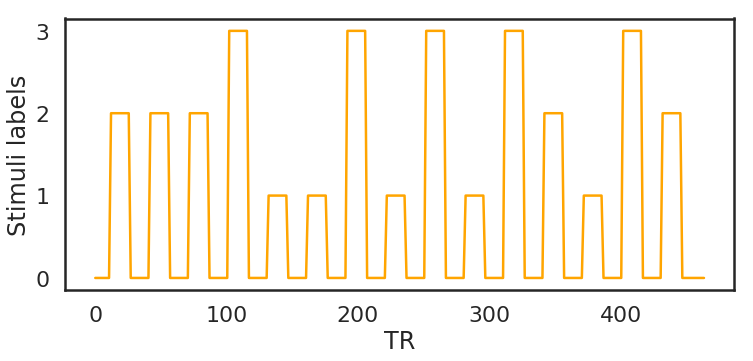

In [8]:
# Create a sequence of timepoints that a TR occurred on
tr_time = np.arange(0, (TRs_run - 1) * 1.5 + 1, 1.5)

# Plot the data
f, ax = plt.subplots(1,1, figsize = (12,5))
ax.plot(tr_time, stim_label_TR[0:TRs_run, 0], c='orange')

ax.set_ylabel('Stimuli labels')
ax.set_xlabel('TR')

**Exercise 2:** <a id="ex2"></a> Add code to save the figure above into your repo (not locally).

###  1.3 Hemodynamic Lag: Time shift the labels <a id="label_shift"></a>

The brain response that we measure with fMRI is slow which means there is a lag between when events occur and when we expect to find changes in the BOLD signal. Below we plot the expected neural response to a single event.

Text(0.5,0,'Time in secs')

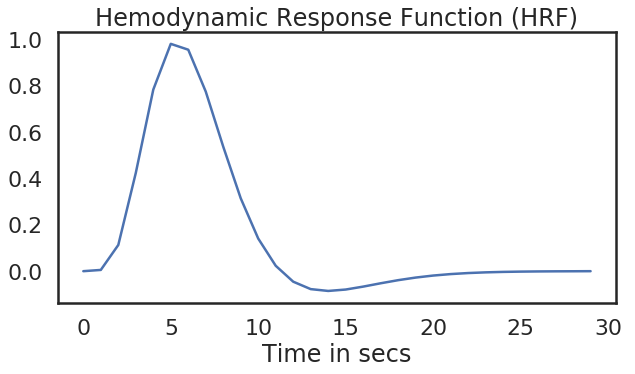

In [9]:
# Older versions of brainiak have different ways of calling this function
hrf = hrf_func(temporal_resolution=1)

# Plot the canonical double gamma HRF
f, ax = plt.subplots(1,1, figsize = (10, 5))
ax.plot(range(30), hrf)

ax.set_title("Hemodynamic Response Function (HRF)")
ax.set_xlabel('Time in secs')

**Self-study:** What does the expected neural response look like if two events evoke the same response, 5 seconds apart?

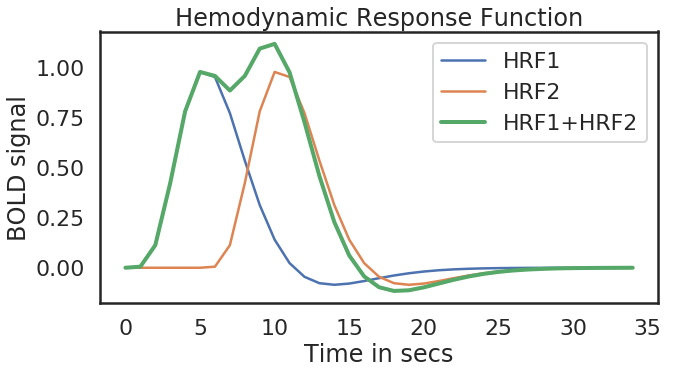

In [10]:
"""What does the expected neural response look like if two events evoke the same response, 5 seconds apart?
"""

n_time_shift = 5
sup_factor = 1

hrf1 = np.hstack([hrf, np.zeros((n_time_shift,))])
hrf2 = np.hstack([np.zeros((n_time_shift,)), hrf])

plt.figure(figsize=(10,5))

plt.plot(hrf1, label = 'HRF1')
plt.plot(hrf2 * sup_factor, label = 'HRF2')
plt.plot(hrf1+hrf2 * sup_factor, label = 'HRF1+HRF2', linewidth = 4)

plt.title("Hemodynamic Response Function")
plt.ylabel('BOLD signal')
plt.xlabel('Time in secs')
plt.legend()

To account for the hemodynamic lag in neural responding we can shift the timecourse of events. First let's plot this timecourse.

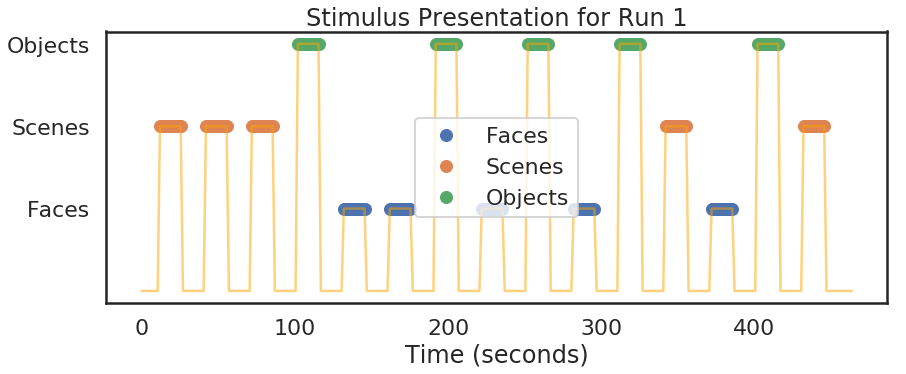

In [11]:
# Create a sequence of timepoints that a TR occurred on
tr_time = np.arange(0, (TRs_run - 1) * 1.5 + 1, 1.5)
time_vals = stim_label_allruns[2, 0:150]
labels = stim_label_allruns[0, 0:150]


f, ax = plt.subplots(1,1, figsize = (14, 5))

all_labels = np.unique(labels)
# plot the stimuli as points
for label in all_labels: 
    mask = label == labels
    ax.plot(time_vals[mask], labels[mask], 'o')
# plot the stimuli as a line 
# ax.plot(time_vals, labels, color = 'black', alpha = .5)
ax.plot(tr_time, stim_label_TR[0:TRs_run, 0], c='orange', alpha = .5)

ax.set_yticks(list(vdc_label_dict.keys()))
ax.set_yticklabels(vdc_label_dict.values())

ax.set_title('Stimulus Presentation for Run 1')
ax.set_xlabel('Time (seconds)')
ax.legend(vdc_label_dict.values())

We need to incorporate this time-shift when we extract the BOLD signal for classification. One way to accomplish this is to shift the labels by 4-5 seconds and extract the BOLD signal for the non-zero labels. As one TR = 1.5 seconds, we'll shift by 3 TRs.

In [12]:
# Shift the data a certain amount

hrf_lag = 4.5  # In seconds what is the lag between a stimulus onset and the peak bold response
shift_size = int(hrf_lag / TR)  # Convert the shift into TRs

# Create a function to shift the size
def shift_timing(label_TR, TR_shift_size):
    
    # Create a short vector of extra zeros
    zero_shift = np.zeros((TR_shift_size, 1))

    # Zero pad the column from the top
    label_TR_shifted = np.vstack((zero_shift, label_TR))

    # Don't include the last rows that have been shifted out of the time line
    label_TR_shifted = label_TR_shifted[0:label_TR.shape[0],0]
    
    return label_TR_shifted

# Apply the function
stim_label_TR_shifted = shift_timing(stim_label_TR, shift_size)

Text(0.5,0,'TR')

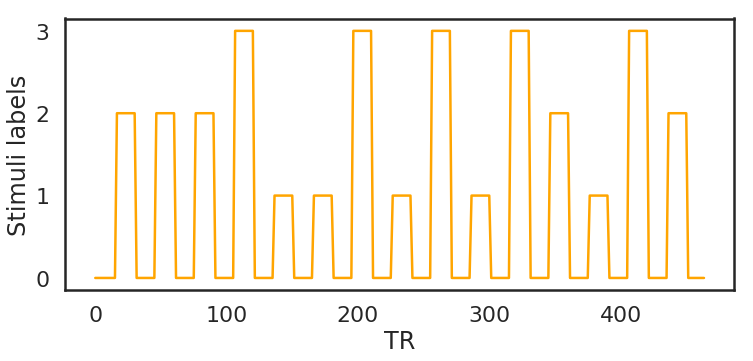

In [13]:
# Add the boxcar to the plot

f, ax = plt.subplots(1,1, figsize = (12,5))
ax.plot(tr_time, stim_label_TR_shifted[0:310], c='orange')

ax.set_ylabel('Stimuli labels')
ax.set_xlabel('TR')

Note how the shifted boxcar is not plotted automatically into the cell above. This is because plotting goes into the figure after plt.figure() was called and will keep writing there (automatically sets 'hold on' if you are familiar with matlab) until you call a new plt.figure().

### 1.4 Load the fMRI data<a id="load_fmri"></a>

As in the exercise from week 2 we will load in, mask, and z-score the data.

In [ ]:
print('available ROIs: ', vdc_all_ROIs)

available ROIs:  ['FFA', 'PPA']


In [ ]:
# Apply the function to pull out the mask data
epi_mask_data_all = load_vdc_masked_data(vdc_data_dir, sub, vdc_all_ROIs)

# Check the dimensionality of the data
print('voxel by TR matrix - shape: ', epi_mask_data_all[vdc_all_ROIs.index('FFA')].shape)
print('label list - shape: ', stim_label_TR_shifted.shape)

## 2. Classification<a id="classification"></a>

We will now build a very basic classifier to categorize our data. We will try two classifier algorithms that you learned about in class.

Each classifier has a number of parameters that can be changed to affect the sensitivity of the classification. For now, we will hard code these parameters. We will cover more principled ways to do classification in a future exercise.

### 2.1 Reshape data <a id="reshape"></a>

First, we extract the time points for which we have stimulus labels -- i.e., we drop the time-points from the BOLD signal that refer to the fixation periods.

In [ ]:
# Extract bold data for non-zero labels
def reshape_data(label_TR_shifted, masked_data_all):
    label_index = np.nonzero(label_TR_shifted)
    label_index = np.squeeze(label_index)
    # Pull out the indexes
    indexed_data = np.transpose(masked_data_all[:,label_index])
    nonzero_labels = label_TR_shifted[label_index] 
    return indexed_data, nonzero_labels

bold_data, labels = reshape_data(
    stim_label_TR_shifted, epi_mask_data_all[vdc_all_ROIs.index('FFA')]
)

# What is the dimensionality of the data? We need the first dim to be the same
print(bold_data.shape)
print(labels.size)

### leave-one-run-out training testing 
we will train the classifier on 2 runs and test it on the holdout run

In [ ]:
# prepare run ids (works similarity to cv_ids)
n_runs = vdc_n_runs 
run_len = labels.size // n_runs
run_ids = np.repeat(range(vdc_n_runs), run_len)

In [ ]:
# select a run
holdout_run_ids = 0
# make a mask
mask = run_ids != holdout_run_ids

# split the training set and test set ... 
X_train = bold_data[mask,]
y_train = labels[mask]
X_test = bold_data[np.logical_not(mask),]
y_test = labels[np.logical_not(mask)]

# normalize: all voxels have zero means and unit var
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# fit a model on the training set 
model = SVC(kernel="linear", C=1, probability=True)  
model.fit(X_train, y_train)

# compute your evaluation on the test set
score = model.score(X_test, y_test)
print(score)

In [ ]:
"""handle the train-test split with sklearn
example: 
ps = PredefinedSplit(run_ids)
for train_index, test_index in ps.split():
    ... 
"""

# loop over all runs 
scores = []

# split data according to run ids 
ps = PredefinedSplit(run_ids)
# data normalizer 
scaler = StandardScaler()
# classifier 
model = SVC(kernel="linear", C=1, probability=True)  

for train_index, test_index in ps.split():
    X_train, X_test = bold_data[train_index], bold_data[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    # normalize the data 
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    # fit a svm
    model.fit(X_train, y_train)
    # calculate the accuracy for the hold out run
    score = model.score(X_test, y_test)
    scores.append(score)
print(scores)

In [ ]:
"""double dipping"""

# data normalizer 
scaler = StandardScaler()
# classifier 
model = SVC(kernel="linear", C=1, probability=True)  

X_train = scaler.fit_transform(bold_data)
# fit a svm
model.fit(X_train, labels)
# calculate the accuracy for the hold out run
score = model.score(X_train, labels)
print(score)

In [ ]:
# pack the classification code as a function... 
def decode(X, y, cv_ids, model): 
    """
    Parameters
    --------------
    X: np.array, n_stimuli x n_voxels
    y: np.array, n_stimuli, 
    cv_ids: np.array - n_stimuli, 
    
    Return
    --------------
    scores
    """
    scores = []
    models = []
    ps = PredefinedSplit(cv_ids)
    scaler = StandardScaler()
    for train_index, test_index in ps.split():
        # split the data 
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        # normalize the data 
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        # fit the model on the training set 
        model.fit(X_train, y_train)
        # calculate the accuracy for the hold out run
        score = model.score(X_test, y_test)
        # save stuff 
        models.append(model)
        scores.append(score)
    return models, scores

In [ ]:
# run the function 
svc = SVC(kernel="linear", C=1, probability=True)  
models, scores = decode(X=bold_data, y=labels, cv_ids=run_ids, model=svc)
print(scores)

In [ ]:
# you can use a different classifier ... 
gnb = GaussianNB()
models, scores = decode(X=bold_data, y=labels, cv_ids=run_ids, model=gnb)
print(scores)

**Exercise:** <a id="ex5"></a> Is this good performance? What would you expect by chance? How could you prove that by changing one line of code above (no need to implement the proof)?

### 2.4 Perform the analysis across participants <a id="across_ppts"></a>

The next step is to run a classifer on a group of subjects. We will now create the condition variable, stim_label_TR, for all subjects and then use it to pull out the relevant participant data and then feed it into a classifier.

Before you run this command, make sure you save your notebook. You will be loading in a lot of data and so it might run into memory issues and crash your job. If you do have issues, change how much memory you request in your run_jupyter.sh script.

**Exercise 7:** <a id="ex7"></a> The code below loops through subjects but the classifier calls are missing (at the bottom). Convert the classifier code above into a function first, then add the function call to the code at the bottom, save your notebook, and then run the code.

**Exercise 8:** <a id="ex8"></a> What is the average accuracy across participants of the GNB and SVM classifiers?

**Novel contribution:** <a id="novel"></a> be creative and make one new discovery by adding an analysis, visualization, or optimization.


## Contributions <a id="contributions"></a> 

M. Kumar, C. Ellis and N. Turk-Browne produced the initial notebook  
T. Meissner minor edits  
Q. Lu a lot of edits... 